In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix ,classification_report
from qiskit import *
from qiskit_ibm_provider import *
from qiskit_ibm_runtime import *
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import *
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import pandas as pd
import seaborn as sns
import time
import psutil
from matplotlib import pyplot as plt
from IPython.display import clear_output
from qiskit.primitives import Sampler

sampler = Sampler()

In [2]:
import pandas as pd
#data_path = "./dataset/"
#train_data = np.loadtxt(data_path + "mnist_train.csv", delimiter=",")
df = pd.read_csv('../dataset/citrus.csv')
df

,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9
...,...,...,...,...,...,...
9995,grapefruit,15.35,253.89,149,77,20
9996,grapefruit,15.41,254.67,148,68,7
9997,grapefruit,15.59,256.50,168,82,20
9998,grapefruit,15.92,260.14,142,72,11


In [3]:
df.isnull().sum()

name        0
diameter    0
weight      0
red         0
green       0
blue        0
dtype: int64

In [4]:
df.describe()

,diameter,weight,red,green,blue
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,9.975685,175.050792,153.847800,76.010600,11.363200
std,1.947844,29.212119,10.432954,11.708433,9.061275
min,2.960000,86.760000,115.000000,31.000000,2.000000
25%,8.460000,152.220000,147.000000,68.000000,2.000000
50%,9.980000,174.985000,154.000000,76.000000,10.000000
75%,11.480000,197.722500,161.000000,84.000000,17.000000
max,16.450000,261.510000,192.000000,116.000000,56.000000


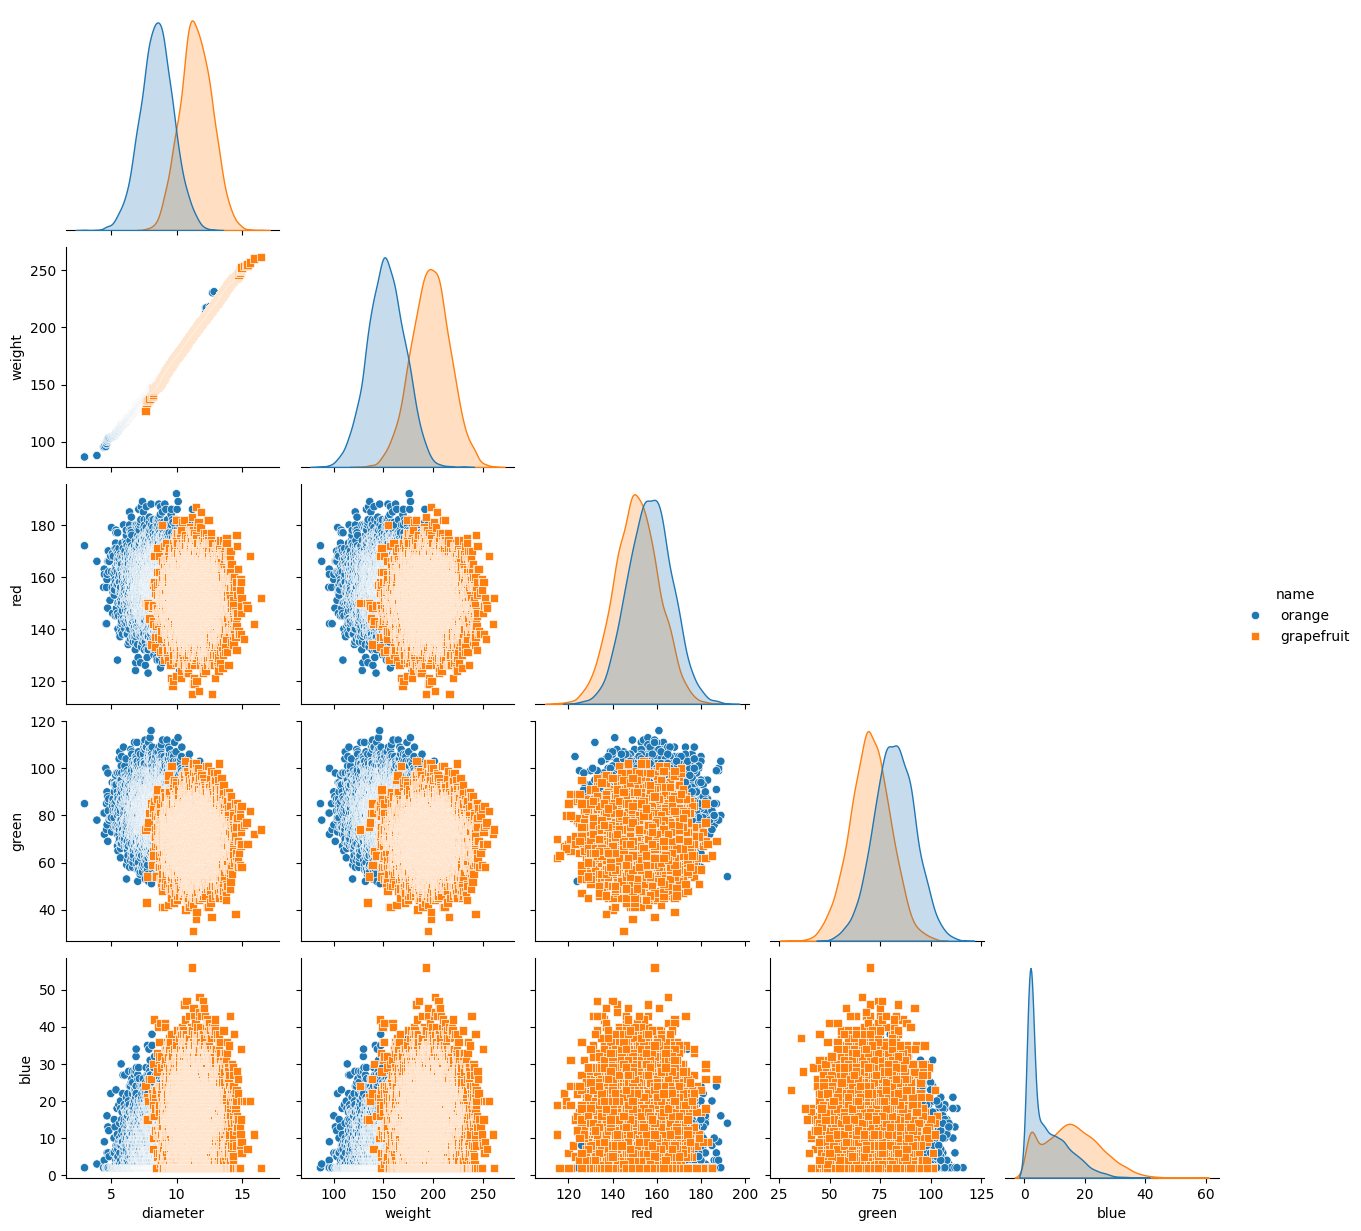

In [5]:
import seaborn as sns
sns.pairplot(df, hue="name", markers=["o", "s"], corner=True);

In [6]:
from IPython.core.magic import register_cell_magic
@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    with open(file, mode) as f:
        f.write(cell)
    get_ipython().run_cell(cell)

In [7]:
data = df.drop('name',axis=1).values
labels = df['name'].values   

In [8]:
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler

x_train, x_test, y_train, y_test = train_test_split(data, labels,  train_size = 0.70, shuffle=True, random_state=42)
# Perform PCA for dimensionality reduction
""""
pca = PCA(n_components=10)  # Reduce features to 10 components
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

print("Original shape of training data:", x_train.shape)
print("Reduced shape of training data after PCA:", x_train_pca.shape)

# If you want to balance the class distribution, you can apply sampling techniques here
# For example:
rus = RandomUnderSampler()
x_train_resampled, y_train_resampled = rus.fit_resample(x_train_pca, y_train)

print("Shape of resampled training data:", x_train_resampled.shape, y_train_resampled.shape)
"""
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7000, 5) (3000, 5) (7000,) (3000,)


In [9]:
num_features = data.shape[1]
num_features

5

In [10]:
%%write_and_run feature_map.py
# The write_and_run function writes the content in this cell into the file "feature_map.py"

### WRITE YOUR CODE BETWEEN THESE LINES - START
import numpy as np
from qiskit import QuantumCircuit 
from qiskit.circuit import ParameterVector

def feature_map(num_qubits): 
    # Build the feature map
    reps = 3
    feature_map_circuit = QuantumCircuit(num_qubits)
    x = ParameterVector('x', length=num_qubits)

    for _ in range(reps):
        for i in range(num_qubits):
            feature_map_circuit.rx(x[i], i)
            feature_map_circuit.rz(x[i], i)
        feature_map_circuit.barrier()
        for control in range(num_qubits-1, 0, -1):
            target = control - 1
            feature_map_circuit.rx(x[target], target)
            feature_map_circuit.cx(control, target)
            feature_map_circuit.rx(x[target], target)
            feature_map_circuit.barrier()
        for i in range(num_qubits):
            feature_map_circuit.rx(x[i], i)
            feature_map_circuit.rz(x[i], i)
        feature_map_circuit.barrier()

    # Return both the circuit and the number of qubits
    return feature_map_circuit, num_qubits


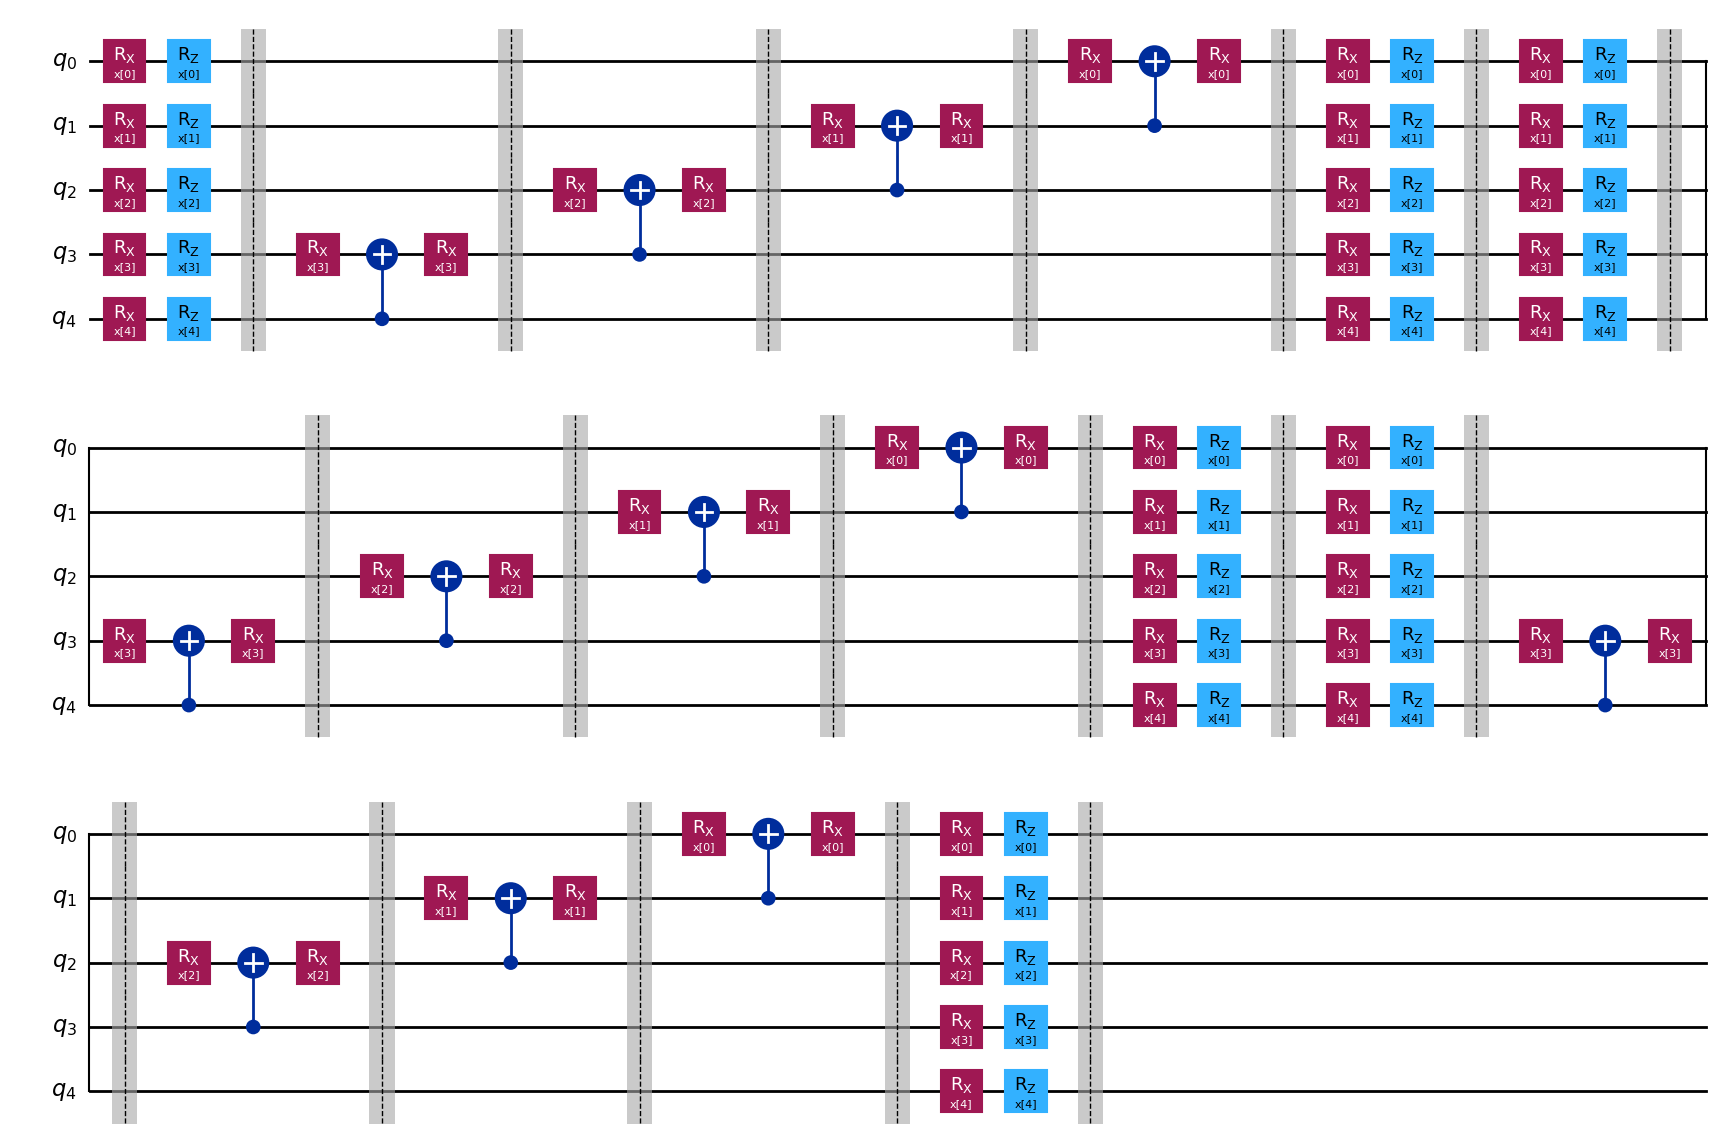

In [11]:

# Initialize the feature map
feature_map_circuit, num_qubits = feature_map(num_qubits=num_features)
feature_map_circuit.draw(output='mpl', filename='final_fmap.jpg')

In [12]:
%%write_and_run variational_circuit.py
# the write_and_run function writes the content in this cell into the file "variational_circuit.py"

### WRITE YOUR CODE BETWEEN THESE LINES - START
    
# import libraries that are used in the function below.
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import  RealAmplitudes, EfficientSU2, TwoLocal, NLocal
    
### WRITE YOUR CODE BETWEEN THESE LINES - END

def variational_circuit(num_qubits):
    # BUILD VARIATIONAL CIRCUIT HERE - START
    
    # import required qiskit libraries if additional libraries are required
    
    # build the variational circuit
    var_circuit = EfficientSU2(num_qubits, entanglement='linear', reps=3, insert_barriers=True)
    #var_circuit = TwoLocal(num_qubits, ['ry', 'rz'], ['cx'], entanglement='linear', reps=4, insert_barriers=True)
    # BUILD VARIATIONAL CIRCUIT HERE - END
    
    # return the variational circuit which is either a VaritionalForm or QuantumCircuit object
    return var_circuit, num_qubits

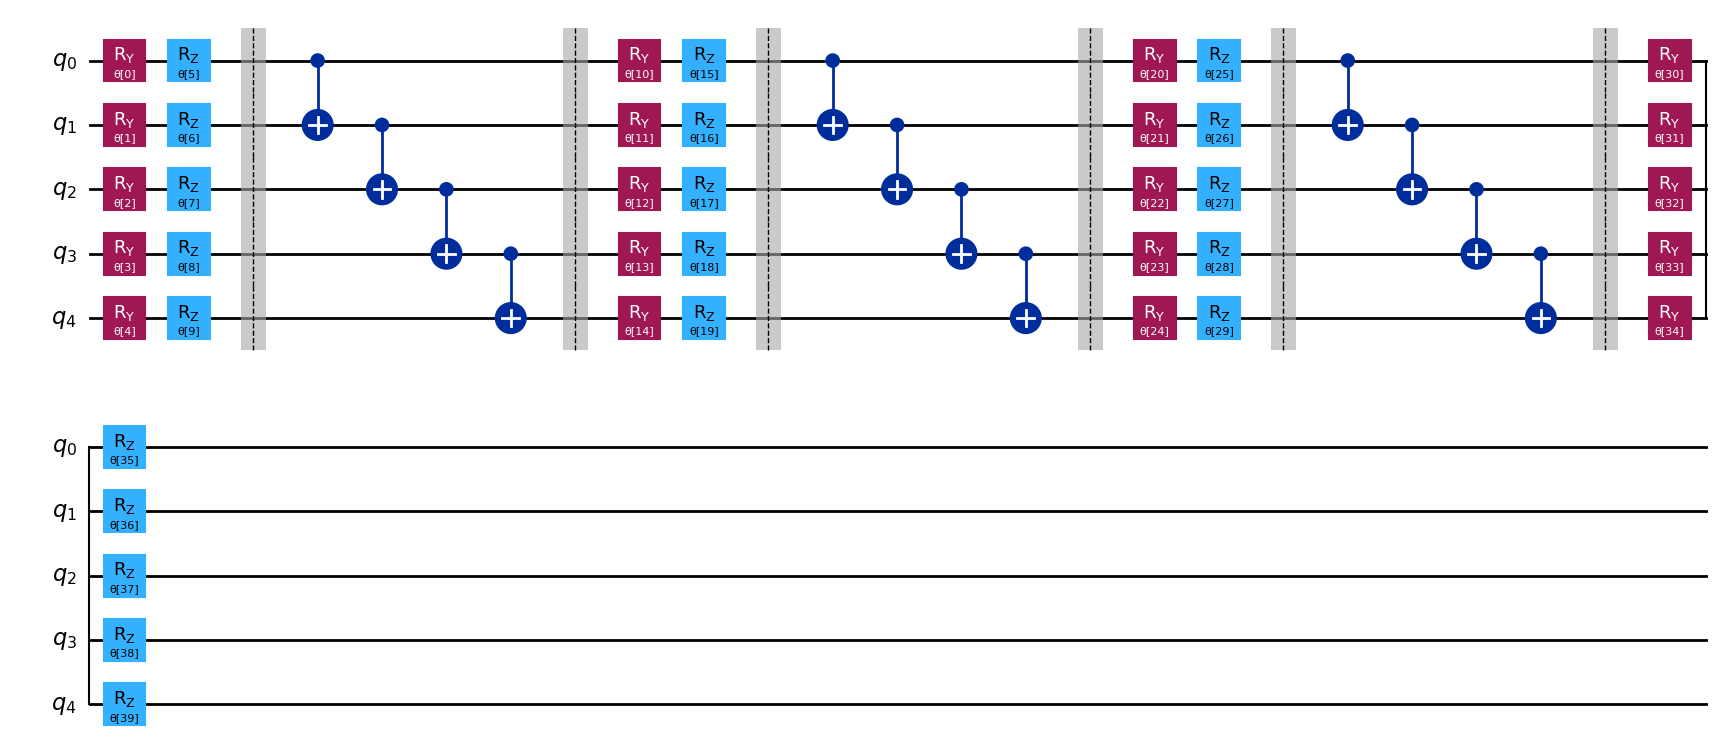

In [13]:
# Initialize the variational circuit
variational_circuit_circuit, num_qubits = variational_circuit(num_qubits=num_features)
variational_circuit_circuit.decompose().draw(output='mpl', filename='final_var_circ.jpg')

In [14]:
cls_opt = COBYLA(maxiter=50, tol=0.001)

In [15]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals))
    , objective_func_vals)
    plt.show()

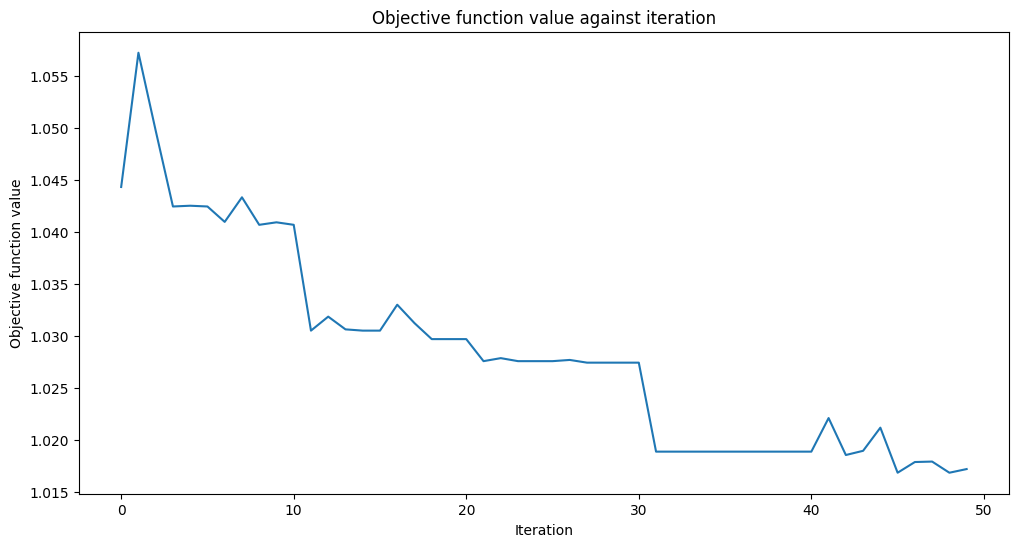

Training time: 1431 seconds


In [16]:
import feature_map, variational_circuit

# Initialize VQC with the derived number of qubits and the feature map
vqc = VQC(
    sampler = sampler,
    num_qubits=num_qubits,
    feature_map=feature_map_circuit,
    ansatz=variational_circuit_circuit,
    optimizer=cls_opt,
    callback=callback_graph,
    loss='cross_entropy',
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(x_train, y_train)
elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

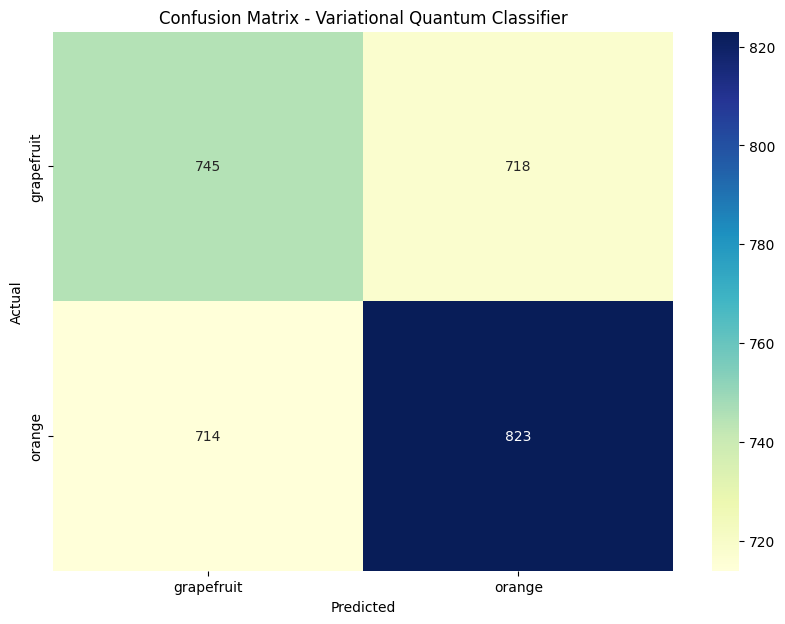

Accuracy = 52.26666666666666
F1 Score = 52.26501079173966


In [17]:
result = vqc.predict(x_test)

conf_mat = confusion_matrix(y_test, result)


# Use unique values of y_test as index and columns for the confusion matrix DataFrame
df_cm = pd.DataFrame(conf_mat, index=np.unique(y_test), columns=np.unique(y_test))

plt.figure(figsize=(10,7))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt='g')
plt.title('Confusion Matrix - Variational Quantum Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

vqc_score = accuracy_score(y_test, result) * 100

print('Accuracy =', vqc_score)
print('F1 Score =', f1_score(y_test, result, average='weighted') *  100)
#evaluate_classifier(vqc)

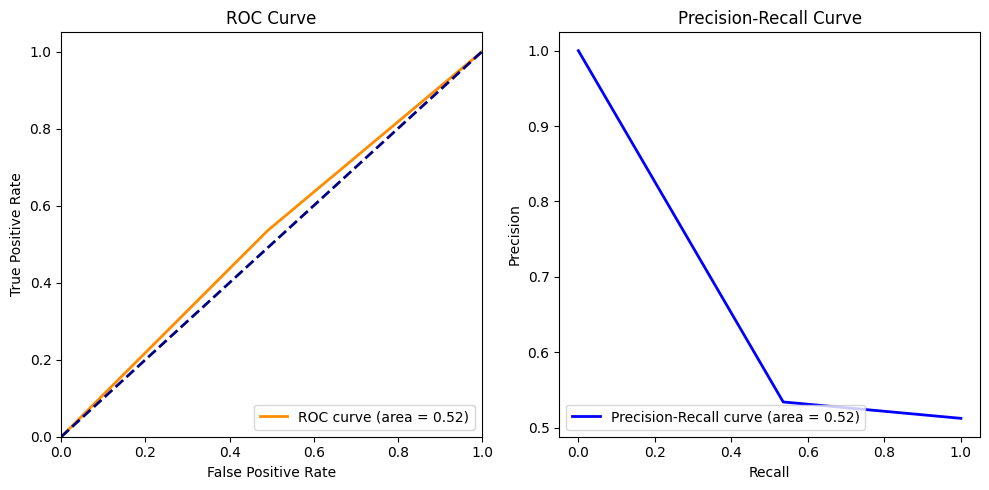

In [18]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have trained and predicted using your classifier 'vqc'

# Convert class labels to binary format
y_test_binary = (y_test == 'orange').astype(int)

# Predict class labels
predicted_labels = vqc.predict(x_test)

# Convert the predicted labels to numeric scores (1 for positive class, 0 for negative class)
result_scores = np.where(predicted_labels == 'orange', 1, 0)

# Compute ROC curve and ROC area for class 1 (orange)
fpr, tpr, _ = roc_curve(y_test_binary, result_scores, pos_label=1)

# Compute Precision-Recall curve and area for class 1 (orange)
precision, recall, _ = precision_recall_curve(y_test_binary, result_scores, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)

# Compute average precision
avg_precision = average_precision_score(y_test_binary, result_scores)
    
# ROC Curve and AUC
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Plot Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % avg_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.tight_layout()

plt.show()


In [19]:
feature_map_circuit.depth()

48

In [20]:
variational_circuit_circuit.decompose().depth()

20